<h1><center>Лабораторна робота 7.</center></h1>
<h2><center>Аналіз активності людини за відкритими даними мобільних телефонів</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="lab-7"></a>

## Зміст

- [7.1. Завантаження та підготовка даних](#lab-7.1)
- [7.2. Застосування методу головних компонент](#lab-7.2)  
- [7.3. Застосування *k*-means](#lab-7.3)
- [7.4. Агломератична кластеризація](#lab-7.4)
- [7.5. Застосування класифікатора після кластеризації](#lab-7.5)
- [7.6. Кластеризація із методом головних компонент](#lab-7.6)

<a class="anchor" id="lab-7.1"></a>

## <span style="color:blue; font-size:1.2em;">7.1. Завантаження та підготовка даних</span>

[Повернутися до змісту](#lab-7)

У цій лабораторній робота Вам потрібно розібратися з тим, як працюють методи пониження розмірності й кластеризації даних. Крім того, ще раз попрактикуємося із задачею класифікації.

Тут ми працюватимемо з набором даних [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Завантажте дані з [репозиторію](https://github.com/radiukpavlo/intelligent-data-analysis/blob/main/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR.zip) на GitHub.

Дані взято з акселерометрів і гіроскопів мобільних телефонів Samsung Galaxy S3 (докладніше щодо ознак – за посиланням на UCI вище), також відомий вид активності людини з телефоном в кишені – чи ходила людина, стояла, лежала, сиділа або йшла вгору/вниз сходами.

Спершу представимо, що вид активності нам невідомий, і спробуємо кластеризувати людей лише на основі наявних свідчень. Далі розв'яжемо завдання визначення виду фізичної активності саме як задачу класифікації.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [10]:
# Завантаження даних, якщо код пишеться в Google Colab

# Підключаємо додаткові бібліотеки для під'єднання Google Colab до власного Googgle Drive
from google.colab import drive
drive.mount('/content/drive')

# Текстові дані потрібно розмістити за наведеним нижче шляхом для кожного текстового файлу.
# Можливо шлях зміниться, залежно від вашого робочого середовища.
X_train = np.loadtxt("https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/812a3f66a744bf99069b49e5162084526f740b2d/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/812a3f66a744bf99069b49e5162084526f740b2d/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/812a3f66a744bf99069b49e5162084526f740b2d/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/812a3f66a744bf99069b49e5162084526f740b2d/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR/samsung_test_labels.txt").astype(int)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Перевіримо розмірності
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризації нам не потрібен вектор відповідей, тому будемо працювати з об'єднанням навчальної та тестової вибірок. Об'єднаємо `X_train` з `X_test` та `y_train` з `y_test`.

In [12]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Визначимо кількість унікальних значень міток цільового класу.

In [13]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [14]:
n_classes = np.unique(y).size
n_classes

6

Ці мітки [відповідають](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names) таким значенням:
- 1 – ходьба;
- 2 – підйом вгору сходами;
- 3 – спуску вниз сходами;
- 4 – сидіння;
- 5 – стояння;
- 6 – лежання.

Виконаємо масштабування вибірки за допомогою `StandardScaler` з параметрами за замовчуванням:

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

------------------------

<a class="anchor" id="lab-7.2"></a>

## <span style="color:blue; font-size:1.2em;">7.2. Застосування методу головних компонент</span>

[Повернутися до змісту](#lab-7)

Виконайте зниження розмірності даних за допомогою PCA. Залишіть таку кількість компонент, щоби пояснити як мінімум 90% дисперсії оброблених (масштабованих) даних. Використовуйте масштабовану вибірку й зафіксуйте random_state (константа RANDOM_STATE).

In [16]:
# Ваш код тут
pca = PCA(0.90, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [17]:
# Переглядаємо кількість компонент
X_pca.shape

(10299, 65)

### <span style="color:red; font-size:1.5em;">Завдання 1</span>


**Для варіантів 1-5:**

Виконайте ще одне пониження розмірності даних, але для пояснення 100% дисперсії. Порівняйте результати з точки зору необхідної кількості компонент.

**Для варіантів 6-10:**

Яку мінімальну кількість головних компонент потрібно виділити, щоб пояснити 90% дисперсії початкових (масштабованих) даних? 

**Для варіантів 11-15:**

Скільки відсотків дисперсії припадає на першу головну компоненту? Використайте метод `explained_variance_ratio_`. Результат округліть до сотих.

**Для варіантів 16-20:**

Виведіть номер головної компоненти, на яку припадає найбільший % дисперсії (для 90% дисперсії). Використайте метод `explained_variance_ratio_`.

### <span style="color:red; font-size:1.5em;">Додаткове завдання</span>

**Для всіх варіантів:**

Відобразіть дані в проекції на перші дві головні компоненти. Для візуалізації використайте `plt.scatter()`. 

Якщо візуалізацію виконано правильно, Ви побачите скільки-то кластерів, майже ідеально відокремлених один від одного. Які види активності входять в ці кластери?

------------------------

In [18]:
len(pca.explained_variance_ratio_)

65

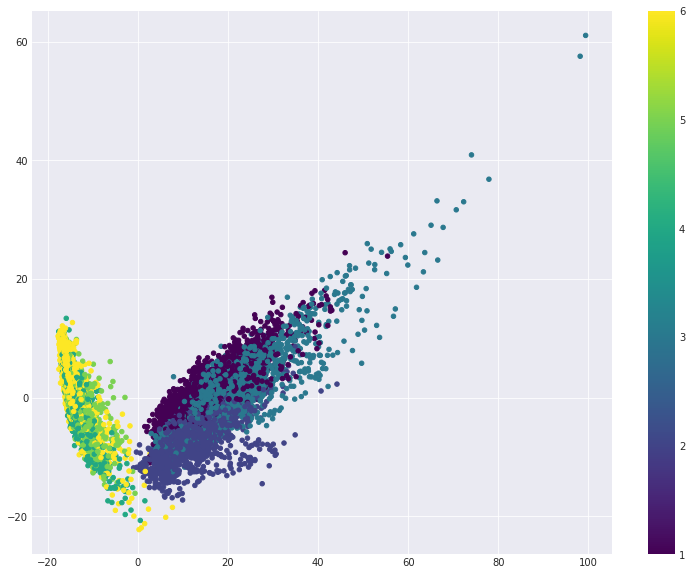

In [19]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');
plt.colorbar()

## <span style="color:blue; font-size:1.2em;">7.3. Застосування *k*-means</span>

[Повернутися до змісту](#lab-7)

Виконайте кластеризацію даних методом `MiniBatchKmeans`, навчивши модель за даними зі зниженою за рахунок PCA розмірністю. Тут потрібно шукати саме 6 кластерів, але загалом у задачах без вчителя ми не знаємо, яку кількість кластерів треба шукати.

Параметри:

- **n_clusters** = n_classes (кількість унікальних міток цільового класу);
- **n_init** = 100;
- **random_state** = RANDOM_STATE (для відтворюваності результату).

Інші параметри залишаються за замовчуванням.

In [20]:
kmeans = MiniBatchKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.predict(X_pca)

Перегляньте відповідність між мітками кластерів і початковими мітками класів, а також гляньте на те, які види активностей алгоритм `MiniBatchKmeans` плутає.

In [21]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'підйом вгору сходами', 
             'спуск вниз сходами', 'сидіння', 'стояння', 'лежання', 'всі']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['всі']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,всі
ходьба,340,0,240,1017,125,0,1722
підйом вгору сходами,278,0,1075,179,12,0,1544
спуск вниз сходами,754,0,163,249,240,0,1406
сидіння,0,1631,33,0,0,113,1777
стояння,0,1896,10,0,0,0,1906
лежання,0,76,35,0,0,1833,1944
всі,1372,3603,1556,1445,377,1946,10299


Бачимо, що кожному класу (тобто кожній активності) відповідають кілька кластерів. Давайте подивимося на максимальну частку об'єктів в класі, що відносяться до якогось одного кластеру. Ця частка буде простокою метрикою, що характеризує наскільки легко клас відділяється від інших під час кластеризування.

Приклад: якщо для класу "спуск сходами", в якому 1406 об'єктів, розподіл кластерів є таким:
 - кластер 1 – 900;
 - кластер 3 – 500;
 - кластер 6 – 6,
 
то така частка буде 900 / 1406 $\approx$ 0.64.

Зазвичай, *k*-means не надто добре відрізняє тільки активності одну від одної. Тому використаємо метод ліктя, щоби вибрати оптимальну кількість кластерів. Параметри алгоритму й дані використовуємо ті ж, що і раніше, міняємо лише `n_clusters`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/6 [00:00<?, ?it/s]

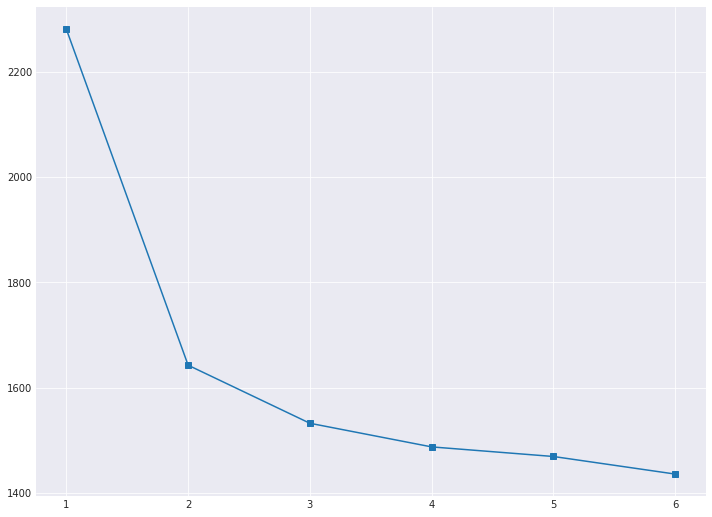

In [23]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 7), inertia, marker='s');

### <span style="color:red; font-size:1.5em;">Завдання 2</span>


**Для варіантів 1-5:**

Яка кількість кластерів є оптимальною? Для відповіді на це запитання використайте метод ліктя, а саме закодуйте $D(k)$ (аналогічно до прикладу з лекції).

**Для варіантів 6-10:**

 Чи правда, що краще обрати 3 кластери для розбиття всієї відмасштабованої вибірки? Для відповіді на це запитання використайте метод ліктя, а саме закодуйте $D(k)$ (аналогічно до прикладу з лекції).

**Для варіантів 11-15:**

Обрахуйте, який вид активності відокремився від інших найкраще за метрикою частки об'єктів в класі (описано вище)?

**Для варіантів 16-20:**

Візуалізуйте дані в проекції на перші дві головні компоненти. Зображіть точки різними кольорами, відповідно до отриманих міток кластерів (`cluster_labels`). Використайте `plt.scatter()`.

In [25]:
inertia = []
for k in tqdm_notebook(range(1, n_classes)):
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

for i in range(1, len(inertia) - 1):
    D = abs(inertia[i] - inertia[i + 1]) / abs(inertia[i - 1] - inertia[i])
    print(D)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

0.17285099347244812
0.4070139367455355
0.40583398074745985


<a class="anchor" id="lab-7.4"></a>

## <span style="color:blue; font-size:1.2em;">7.4. Агломератична кластеризація</span>

[Повернутися до змісту](#lab-7)

Спробуємо ще один алгоритм, що входить до групи ієрархічної кластеризації – агломеративну кластеризацію [`AgglomerativeClustering()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

In [26]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit_predict(X_pca)

Обрахуйте Adjusted Rand Index (ARI) для розбиття на два кластери за [`AgglomerativeClustering()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) та [`MiniBatchKmeans()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) з параметрами із пункту 7.3.

Відповідно до знайденого значення ARI, дайте відповіді на запитання нижче.

In [27]:
metrics.adjusted_rand_score(y, ag)

0.49362763373004886

In [28]:
metrics.adjusted_rand_score(y, cluster_labels)

0.5342207745672404

### <span style="color:red; font-size:1.5em;">Завдання 3</span>


**Для варіантів 1-5:**

Порівняйте значення ARI, знайденого для `AgglomerativeClustering()` та `MiniBatchKmeans()`. Поясніть, чому ці значення різні.

**Для варіантів 6-10:**

Відповідно до виконаних обрахунків, що впливає на значення ARI? Присвоєні мітки чи розбиття об'єктів на кластери? Наведіть коротке пояснення.

**Для варіантів 11-15:**

Чи правда, що для нашого прикладу `AgglomerativeClustering()` впорався з кластеризацією гірше, ніж `MiniBatchKmeans()`? Чому?

**Для варіантів 16-20:**

Чи правда, що у разі випадкового розбиття на кластери ARI буде близький до нуля. Чому?

Для ARI немає значення, які саме значення мітки присвоєні кластерам, має значення лише розбиття об'єктів на кластери.

<a class="anchor" id="lab-7.5"></a>

## <span style="color:blue; font-size:1.2em;">7.5. Застосування класифікатора після кластеризації</span>

[Повернутися до змісту](#lab-7)

Можна помітити, що завдання не надто добре розв'язується саме як задача кластеризації, якщо виділяти лише кілька кластерів (>2). Спробуємо тепер розв'яжемо задачу класифікації; пам'ятаємо, що дані у нас розмічені.

Для класифікації використайте метод опорних векторів – клас `sklearn.svm.LinearSVC`. В межах курсу ми не розглядали відокремлено цей алгоритм, проте він вкрай відомий, почитати про нього можна, наприклад, в документації scikit-learn під назвою [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html#). 

Налаштуйте для `LinearSVC` гіперпараметр `C` за допомогою `GridSearchCV` (cv=3). Виконайте навчання нового `StandardScaler` за навчальною вибіркою (з усіма початковими ознаками), застосуйте масштабування до тестової вибірки.

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [31]:
%%time
best_svc = GridSearchCV(svc, param_grid=svc_params, cv=3).fit(X_train_scaled, y_train)
best_svc = best_svc.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

CPU times: user 1min 17s, sys: 1.28 s, total: 1min 19s
Wall time: 1min 24s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [32]:
best_svc.C

0.1

Виконайте прогноз за тестовим набором даних:

In [33]:
y_predicted = best_svc.predict(X_test_scaled)

Вивидимо результат розподілення класів у таблиці:

In [34]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'підйом вгору сходами', 'спуску вниз сходами', 
             'сидіння', 'стояння', 'лежання', 'всі']
tab.columns = tab.index
tab

,ходьба,підйом вгору сходами,спуску вниз сходами,сидіння,стояння,лежання,всі
ходьба,494,2,0,0,0,0,496
підйом вгору сходами,12,459,0,0,0,0,471
спуску вниз сходами,2,3,414,1,0,0,420
сидіння,0,4,0,426,61,0,491
стояння,0,0,0,15,517,0,532
лежання,0,0,0,0,11,526,537
всі,508,468,414,442,589,526,2947


### <span style="color:red; font-size:1.5em;">Завдання 4</span>

Для відповіді на запитання нижче використайте `metrics.classification_report()`:

**Для варіантів 1-5:**

Обрахуйте частку правильних відповідей (accuracy) класифікатора SVM? Виведіть значення відповідної метрики за допомогою коду.

**Для варіантів 6-10:**

Який вид активності SVM визначає найгірше за метрикою влучності (precision)? Виведіть назву відповідної ознаки (вид активності) та значення відповідної метрики за допомогою коду.

**Для варіантів 11-15:**

Який вид активності SVM визначає найгірше за метрикою повноти (recall)? Виведіть назву відповідної ознаки (вид активності) та значення відповідної метрики за допомогою коду.

**Для варіантів 16-20:**

Який вид активності SVM визначає найгірше за метрикою $F$-міри (f1-score)? Виведіть назву відповідної ознаки (вид активності) та значення відповідної метрики за допомогою коду.

------------------------

In [35]:
metrics_ = metrics.classification_report(y_test, y_predicted, target_names=tab.index[:6])
print(metrics_)

                      precision    recall  f1-score   support

              ходьба       0.97      1.00      0.98       496
підйом вгору сходами       0.98      0.97      0.98       471
 спуску вниз сходами       1.00      0.99      0.99       420
             сидіння       0.96      0.87      0.91       491
             стояння       0.88      0.97      0.92       532
             лежання       1.00      0.98      0.99       537

            accuracy                           0.96      2947
           macro avg       0.97      0.96      0.96      2947
        weighted avg       0.96      0.96      0.96      2947



<a class="anchor" id="lab-7.6"></a>

## <span style="color:blue; font-size:1.2em;">7.6. Класифікація із методом головних компонент</span>

[Повернутися до змісту](#lab-7)

Виконайте навчання класифікатора, повторивши всі попередні дії (завдання 4) з додаванням PCA:

- Використовуйте вибірки `X_train_scaled` і `X_test_scaled`.
- Навчіть той же PCA, що й раніше за масштабованою навчальною вибіркою; застосуйте перетворення до тестової вибірки.
- Налаштуйте гіперпараметр `C` на крос-валідації за навчальною вибіркою з PCA-перетворенням.

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [37]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [38]:
%%time
best_svc_pca = GridSearchCV(svc, param_grid=svc_params, cv=3).fit(X_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

CPU times: user 15.4 s, sys: 1.42 s, total: 16.8 s
Wall time: 15.9 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### <span style="color:red; font-size:1.5em;">Завдання 5</span>

Обрахуйте метрики за класифікатором SVM та з використанням PCA:

**Для варіантів 1-5:**

Яка різниця між кращою якістю (accuracy) на крос-валідації за використанням всіх 561 початкових ознак і за  використання методу головних компонент? Заокругліть значення метрики до сотих.

**Для варіантів 6-10:**

Порівняйте значення влучності (precision), отриманого за всіма ознаками (завдання 4) і з використанням PCA. Вкажіть переваги/недоліки застосування PCA до навчальної вибірки.

**Для варіантів 11-15:**

Порівняйте значення повноти (recall), отриманого за всіма ознаками (завдання 4) і з використанням PCA. Вкажіть переваги/недоліки застосування PCA до навчальної вибірки.

**Для варіантів 16-20:**

Порівняйте значення $F$-міри (f1-score), отриманої за всіма ознаками (завдання 4) і з використанням PCA. Вкажіть переваги/недоліки застосування PCA до навчальної вибірки.

In [40]:
y_predicted_pca = best_svc_pca.predict(X_test_pca)
tab = pd.crosstab(y_test, y_predicted_pca, margins=True)
tab.index = ['ходьба', 'підйом вгору сходами', 'спуску вниз сходами', 
             'сидіння', 'стояння', 'лежання', 'всі']
tab.columns = tab.index
tab

,ходьба,підйом вгору сходами,спуску вниз сходами,сидіння,стояння,лежання,всі
ходьба,485,6,4,0,0,1,496
підйом вгору сходами,45,408,18,0,0,0,471
спуску вниз сходами,9,26,383,0,1,1,420
сидіння,0,3,0,403,85,0,491
стояння,3,0,0,34,495,0,532
лежання,0,0,0,1,0,536,537
всі,542,443,405,438,581,538,2947


In [41]:
metrics_pca = metrics.classification_report(y_test, y_predicted_pca, target_names=tab.index[:6])
print(metrics_pca)

                      precision    recall  f1-score   support

              ходьба       0.89      0.98      0.93       496
підйом вгору сходами       0.92      0.87      0.89       471
 спуску вниз сходами       0.95      0.91      0.93       420
             сидіння       0.92      0.82      0.87       491
             стояння       0.85      0.93      0.89       532
             лежання       1.00      1.00      1.00       537

            accuracy                           0.92      2947
           macro avg       0.92      0.92      0.92      2947
        weighted avg       0.92      0.92      0.92      2947

